In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.preprocessing import sequence, text
from keras.utils import np_utils, plot_model
import pickle
from classes import *
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from unidecode import unidecode
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import pydot
import graphviz
import time
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [2]:
#para usar solo una GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf 
from keras.backend.tensorflow_backend import set_session 
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 1
set_session(tf.Session(config = config))

In [3]:
#Loading the pickle file with the dictionary Journal - List of headlines
#f = open('titulares_creados/headlines_final.pckl', 'rb')
f = open('titulares_creados/all_headlines.pckl', 'rb')
lista_periodicos = pickle.load(f)
f.close()

In [4]:
#Creating the Headlines object from the pickle file
ep = 'http://ep00.epimg.net/rss/elpais/portada.xml'
em = 'http://estaticos.elmundo.es/elmundo/rss/portada.xml'
lv = 'http://www.lavanguardia.com/mvc/feed/rss/home.xml'
lr = 'http://www.larazon.es/rss/portada.xml'
abc = 'http://www.abc.es/rss/feeds/abcPortada.xml'

urls = [ep, em, lv, lr, abc]
journals = ['El Pais', 'El Mundo', 'La Vanguardia', 'La Razon', 'ABC']

data = Headlines(periodicos=journals, urls=urls, titulares=lista_periodicos) 

In [5]:
#Creating dataframe from the headlines
periodicos_df = Headlines.dataframing_headlines(data)
periodicos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51334 entries, 0 to 51333
Data columns (total 2 columns):
Headline    51334 non-null object
Journal     51334 non-null object
dtypes: object(2)
memory usage: 802.2+ KB


In [6]:
# How many headlines there are of each journal?
# We should limit the number of headlines in each journal to the minimum number available for one of the classes
min_number = Headlines.min_hl_number(data, periodicos_df) 

('El Pais', 5238)
('El Mundo', 15209)
('La Vanguardia', 19490)
('La Razon', 5417)
('ABC', 5980)


In [7]:
min_per_df = Headlines.keeping_min_headlines(data, periodicos_df, min_number)
min_per_df

,Headline,Journal
0,China cierra las puertas a Justin Bieber por s...,La Razon
1,Neymardo Da Vinci,La Vanguardia
2,Miriam Blasco se casó con la rival a la que ga...,El Pais
3,Se confirmaron las sospechas: Jorge gana ‘Mast...,La Razon
4,El Gobierno niega que haya perdido la batalla ...,La Vanguardia
5,Hacienda denuncia al Govern de Puigdemont por ...,El Mundo
6,Localizada con vida la cuidadora de niños alic...,La Razon
7,El cambio de hora de otoño: una vuelta atrás n...,El Pais
8,"Muere la actriz francesa Jeanne Moreau, musa d...",La Vanguardia
9,Detenido un hombre en Marsella tras atropellar...,La Razon


In [8]:
# Obtaining concantenated headlines in order to build the dictionary
concatenated_hl = Headlines.concatenate_headlines(data, df = min_per_df)

In [9]:
# Building dictionary from headlines
sequence_hl = Text_Sequence(concatenated_hl)
dictionary_hl, len_dict = Text_Sequence.creating_dict(sequence_hl)
print 'The dictionary contains', len_dict, 'words'

The dictionary contains 25031 words


In [10]:
# Mapping headlines to integer
x_int = Headlines.headlines_to_int(data, min_per_df, dictionary_hl)
x_int

array([ list([5671, 5770, 14554, 19602, 1292, 14284, 4196, 18865, 22416, 15309, 6277, 24893, 14598, 8129, 19682, 15241]),
       list([16892, 7422, 24509]),
       list([16180, 4286, 21545, 5258, 6339, 14462, 20963, 1292, 14462, 19682, 11704, 9246, 17520, 9481, 3925, 1277]),
       ...,
       list([12488, 24631, 14462, 14151, 15652, 23657, 7533, 23862, 17673, 19682, 21545, 7122, 22416, 7807]),
       list([23862, 12476, 21545, 22556, 1292, 14462, 4664, 7533, 15090, 8983, 14163, 9481, 9246, 17755, 7533, 22708]),
       list([13733, 7741, 5752, 7533, 2365, 23573, 2634, 7533, 11545, 21995, 10593])], dtype=object)

In [11]:
#one-hot-encoding output
#encoder = LabelEncoder()
#encoder.fit(periodicos_df.loc[:,"Journal"])
#El encoding va por orden alfabetico
#encoded_Y = encoder.transform(periodicos_df.loc[:,"Journal"])
# convert integers to dummy variables (i.e. one hot encoded)
#dummy_y = np_utils.to_categorical(encoded_Y)
#dummy_y

In [12]:
# Labelling journal names 
y_int = Headlines.y_to_int(data, min_per_df)
y_int

array([3, 2, 0, ..., 1, 2, 4])

In [13]:
y_int[0:20]

array([3, 2, 0, 3, 2, 1, 3, 0, 2, 3, 2, 0, 1, 0, 3, 2, 2, 4, 1, 4])

In [14]:
y_onehot = np_utils.to_categorical(y_int)
y_onehot

array([[ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [15]:
# In Keras, sequences must have the same length
# Searching for the longest length of headlines
max_headline_lenght = Headlines.max_hl_length(data, x_int)

The longest headline consists of 29 words


In [16]:
#truncate and pad input sequences
x_samelength = sequence.pad_sequences(x_int, maxlen=max_headline_lenght)
x_samelength

array([[    0,     0,     0, ...,  8129, 19682, 15241],
       [    0,     0,     0, ..., 16892,  7422, 24509],
       [    0,     0,     0, ...,  9481,  3925,  1277],
       ..., 
       [    0,     0,     0, ...,  7122, 22416,  7807],
       [    0,     0,     0, ..., 17755,  7533, 22708],
       [    0,     0,     0, ..., 11545, 21995, 10593]], dtype=int32)

In [17]:
# Dividing between training and test set
x_train, x_test, y_train, y_test = Headlines.splitting_data(data, x_samelength, y_onehot, 0.1)

In [18]:
# Loading a pre-trained Spanish embedding 
words, embeddings = pickle.load(open('polyglot-es.pkl', 'rb'))
print("Emebddings shape is {}".format(embeddings.shape))

Emebddings shape is (100004, 64)


In [31]:
#Defining Adam optimizer
epochss = 1000
learning_rate = 5e-4
decay_rate = learning_rate/epochss
adamm = Adam(lr=learning_rate, beta_1=0.1, beta_2=0.001, epsilon=1e-08, decay=decay_rate)

In [32]:
#create the LSTM model
def baseline_model():
#first layer: embedded layer. uses 5 length vectors to represent each word
    embedding_vector_length = 64
    model=Sequential()
    
    #model.add(Embedding(len_dict, embedding_vector_length, input_length=max_headline_lenght))
    model.add(Embedding(100004, embedding_vector_length, trainable =False, weights= [embeddings], input_length=max_headline_lenght))
    
    model.add(Dropout(0.35))
    model.add(Conv1D(filters=embedding_vector_length, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Conv1D(filters=embedding_vector_length, kernel_size=5, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=5))
    model.add(Dropout(0.5))
    #model.add(Flatten())
#Next layer: LSTM layer with 100 memory units
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
    #model.add(Dropout(0.5))
    
#Final layer: Dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions
#model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
#Because we used a one-hot encoding for our iris dataset, the output layer must create 3 output values, one for each class.
#model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(5, activation='softmax'))

#Because it is a binary classification problem, log loss is used as the loss function 
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Because it is a multi-class classification problem, categorical cross entropy is used as the loss function
    #model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer = adamm, metrics=['accuracy'])
    print(model.summary())
    return model

In [23]:
# WAY 1: sckikit-learn wrapper of keras classifier
# that means we can use the standard sklearn functions (model.fit(), model.predict()...)
#estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=epochss, batch_size=5, verbose=0)

In [24]:
#plot_model(baseline_model(), to_file='model.png')

In [25]:
#Checking how tuning goes
#model1 = DL_model(estimator, x_train, y_train, x_test, y_test)
#Measuring time of the tuning
#start_time = time.time()
#DL_model.tuning_dl_model(model1)
#print(" ---%s seconds ---" % (time.time() - start_time))

In [26]:
#estimator.fit(x_train, y_train)

In [21]:
# WAY 2: no sklearn wrapper, simply using keras
model = baseline_model()
#history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=200, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 64)            6400256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 64)            12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________

In [27]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [23]:
#history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=epochss, batch_size=128, callbacks=callbacks_list)

history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=epochss, batch_size=128)

Train on 23571 samples, validate on 2619 samples
Epoch 1/500
23571/23571 [==============================] - 8s - loss: 1.6024 - acc: 0.2205 - val_loss: 1.5804 - val_acc: 0.2593
Epoch 2/500
23571/23571 [==============================] - 7s - loss: 1.5898 - acc: 0.2485 - val_loss: 1.5761 - val_acc: 0.2574
Epoch 3/500
23571/23571 [==============================] - 7s - loss: 1.5857 - acc: 0.2526 - val_loss: 1.5721 - val_acc: 0.2596
Epoch 4/500
23571/23571 [==============================] - 7s - loss: 1.5814 - acc: 0.2617 - val_loss: 1.5696 - val_acc: 0.2642
Epoch 5/500
23571/23571 [==============================] - 7s - loss: 1.5798 - acc: 0.2632 - val_loss: 1.5666 - val_acc: 0.2658
Epoch 6/500
23571/23571 [==============================] - 7s - loss: 1.5769 - acc: 0.2680 - val_loss: 1.5651 - val_acc: 0.2764
Epoch 7/500
23571/23571 [==============================] - 7s - loss: 1.5771 - acc: 0.2668 - val_loss: 1.5661 - val_acc: 0.2658
Epoch 8/500
23571/23571 [==============================

23571/23571 [==============================] - 7s - loss: 1.5424 - acc: 0.3105 - val_loss: 1.5364 - val_acc: 0.2971
Epoch 128/500
23571/23571 [==============================] - 7s - loss: 1.5437 - acc: 0.3068 - val_loss: 1.5386 - val_acc: 0.2971
Epoch 129/500
23571/23571 [==============================] - 7s - loss: 1.5430 - acc: 0.3079 - val_loss: 1.5347 - val_acc: 0.2959
Epoch 130/500
23571/23571 [==============================] - 7s - loss: 1.5441 - acc: 0.3075 - val_loss: 1.5366 - val_acc: 0.2967
Epoch 131/500
23571/23571 [==============================] - 7s - loss: 1.5432 - acc: 0.3098 - val_loss: 1.5353 - val_acc: 0.2959
Epoch 132/500
23571/23571 [==============================] - 7s - loss: 1.5439 - acc: 0.3109 - val_loss: 1.5370 - val_acc: 0.3028
Epoch 133/500
23571/23571 [==============================] - 7s - loss: 1.5462 - acc: 0.3064 - val_loss: 1.5373 - val_acc: 0.2982
Epoch 134/500
23571/23571 [==============================] - 7s - loss: 1.5447 - acc: 0.3107 - val_loss:

23571/23571 [==============================] - 7s - loss: 1.5365 - acc: 0.3118 - val_loss: 1.5282 - val_acc: 0.3093
Epoch 254/500
23571/23571 [==============================] - 7s - loss: 1.5381 - acc: 0.3172 - val_loss: 1.5328 - val_acc: 0.3016
Epoch 255/500
23571/23571 [==============================] - 7s - loss: 1.5384 - acc: 0.3108 - val_loss: 1.5352 - val_acc: 0.2948
Epoch 256/500
23571/23571 [==============================] - 7s - loss: 1.5426 - acc: 0.3139 - val_loss: 1.5330 - val_acc: 0.2982
Epoch 257/500
23571/23571 [==============================] - 7s - loss: 1.5418 - acc: 0.3120 - val_loss: 1.5344 - val_acc: 0.3024
Epoch 258/500
23571/23571 [==============================] - 7s - loss: 1.5420 - acc: 0.3084 - val_loss: 1.5345 - val_acc: 0.2967
Epoch 259/500
23571/23571 [==============================] - 7s - loss: 1.5376 - acc: 0.3146 - val_loss: 1.5344 - val_acc: 0.3009
Epoch 260/500
23571/23571 [==============================] - 7s - loss: 1.5431 - acc: 0.3122 - val_loss:

23571/23571 [==============================] - 7s - loss: 1.5368 - acc: 0.3164 - val_loss: 1.5312 - val_acc: 0.3043
Epoch 380/500
23571/23571 [==============================] - 7s - loss: 1.5302 - acc: 0.3184 - val_loss: 1.5299 - val_acc: 0.3055
Epoch 381/500
23571/23571 [==============================] - 7s - loss: 1.5379 - acc: 0.3148 - val_loss: 1.5302 - val_acc: 0.3009
Epoch 382/500
23571/23571 [==============================] - 7s - loss: 1.5350 - acc: 0.3131 - val_loss: 1.5295 - val_acc: 0.3051
Epoch 383/500
23571/23571 [==============================] - 7s - loss: 1.5384 - acc: 0.3174 - val_loss: 1.5292 - val_acc: 0.3036
Epoch 384/500
23571/23571 [==============================] - 7s - loss: 1.5354 - acc: 0.3159 - val_loss: 1.5305 - val_acc: 0.3055
Epoch 385/500
23571/23571 [==============================] - 7s - loss: 1.5384 - acc: 0.3153 - val_loss: 1.5273 - val_acc: 0.3070
Epoch 386/500
23571/23571 [==============================] - 7s - loss: 1.5381 - acc: 0.3146 - val_loss:

In [24]:
# load the network weights
filename = "weights-improvement-440-0.3196.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [25]:
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


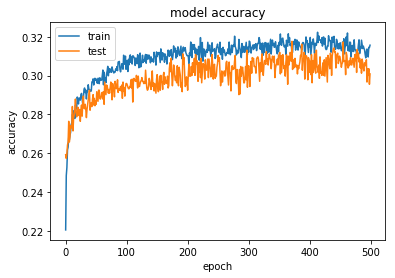

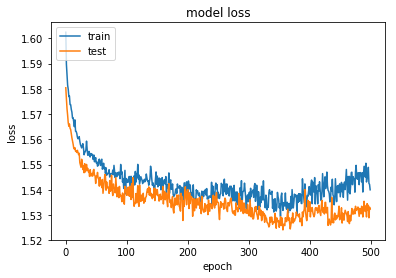

In [26]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
y_predprob = model.predict(x_test)
y_pred = model.predict_classes(x_test)
y_pred_decoded = Headlines.int_to_journal(data, y_pred)

y_trpred = model.predict_classes(x_train)
y_trpred_decoded = Headlines.int_to_journal(data, y_trpred)

23571/23571 [==============================] - 7s     


In [28]:
#Predicting in the test set
#y_pred = estimator.predict(x_test)
#y_pred_decoded = Headlines.int_to_journal(data, y_pred)
#y_pred = encoder.inverse_transform(predictions)

#y_predprob = estimator.predict_proba(x_test)[:,1]
#y_trpred = estimator.predict(x_train)
#y_trpred_decoded = Headlines.int_to_journal(data, y_trpred)

y_pred

array([0, 1, 4, ..., 2, 4, 4])

In [29]:
#Both y_train and y_test are one-hot-encoded. Decoding them for model reporting.
y_train_tocat = Headlines.onehot_to_categorical(data, y_train)
y_test_tocat = Headlines.onehot_to_categorical(data, y_test)

In [30]:
#Print model report:
print ("\nModel Report")
print ("Accuracy (train set): %.4g" % metrics.accuracy_score(y_train_tocat, y_trpred))
print ("Accuracy (test set): %.4g" % metrics.accuracy_score(y_test_tocat, y_pred))
print("Confusion matrix:")
print (metrics.confusion_matrix(y_test_tocat, y_pred))
print("Detailed classification report:")
print (metrics.classification_report(y_test_tocat, y_pred))


Model Report
Accuracy (train set): 0.352
Accuracy (test set): 0.3196
Confusion matrix:
[[147  90  74  72 161]
 [ 62 122  42  55 240]
 [ 85  92 137  35 169]
 [ 80 103  51  89 212]
 [ 65  53  24  17 342]]
Detailed classification report:
             precision    recall  f1-score   support

          0       0.33      0.27      0.30       544
          1       0.27      0.23      0.25       521
          2       0.42      0.26      0.32       518
          3       0.33      0.17      0.22       535
          4       0.30      0.68      0.42       501

avg / total       0.33      0.32      0.30      2619



In [ ]:
# Evaluating the model with k-Fold Validation
seed=7
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

array([[    0,     0,     0, ...,  7533, 14462, 17388],
       [    0,     0,     0, ...,  2007,  7741,  4501],
       [    0,     0,     0, ..., 20495,  1292, 21403],
       ..., 
       [    0,     0,     0, ...,  9596,  9481,  5321],
       [    0,     0,     0, ..., 19753, 15652, 11950],
       [    0,     0,     0, ...,  1455,  7533,  2718]], dtype=int32)

array([[    0,     0,     0, ...,  6473,  9481,  5321],
       [    0,     0,     0, ...,  3053,  9481, 13716],
       [    0,     0,     0, ..., 23167,  9481, 15070],
       ..., 
       [    0,     0,     0, ...,  9409,  2094, 15229],
       [    0,     0,     0, ..., 17883,  7533, 10077],
       [    0,     0,     0, ..., 14462, 17432, 24253]], dtype=int32)